<a href="https://colab.research.google.com/github/fsemecurbe/MMTMSS/blob/main/MMTMSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Multifractals To Modelize Spatial Segregation

In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.measure import block_reduce

## Functions

In [2]:
def multivariate_lognormal_cascade(n, sigma1=1, sigma2=1, corr=0):
    mu1 = -1/2 * sigma1**2
    mu2 = -1/2 * sigma2**2

    PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),  np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), 4))

    P = PQ[:,0].reshape(2,2)
    Q = PQ[:,1].reshape(2,2)
    for i in range(n):
        PQ = np.exp(rng.multivariate_normal(np.array([mu1,mu2]),np.array([[sigma1**2,corr*sigma1*sigma2], [corr*sigma1*sigma2, sigma2**2]]), P.shape[0]**2 * 4))
        P = np.kron(P, np.ones((2,2)))
        P = P * PQ[:,0].reshape(P.shape)
        Q = np.kron(Q, np.ones((2,2)))
        Q = Q * PQ[:,1].reshape(P.shape)

    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    return(np.stack([P,Q], axis=-1))

#### Test de la fonction multivariate_lognormal_cascade

In [3]:
lnc = multivariate_lognormal_cascade(6, sigma1=.4, sigma2=.4, corr=.0)
ratio = .2 * lnc[:,:,0] / (.2 * lnc[:,:,0] + .8 * lnc[:,:,1]) * 100

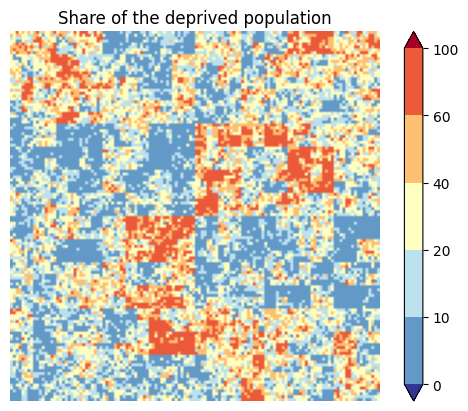

In [4]:
cmap = mpl.cm.RdYlBu_r
bounds = [0, 10, 20, 40, 60, 100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()
ax.set_axis_off();
ax.set_title('Share of the deprived population');
ax.imshow(cmap(norm(ratio)))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax);

### Calcul d'entropie

In [11]:
lnc = multivariate_lognormal_cascade(8, sigma1=.5, sigma2=.4, corr=.0)
pop = lnc[:,:,0]

4.367609253881291
3.9894415616950356
3.5139924176129855
2.995962875001773


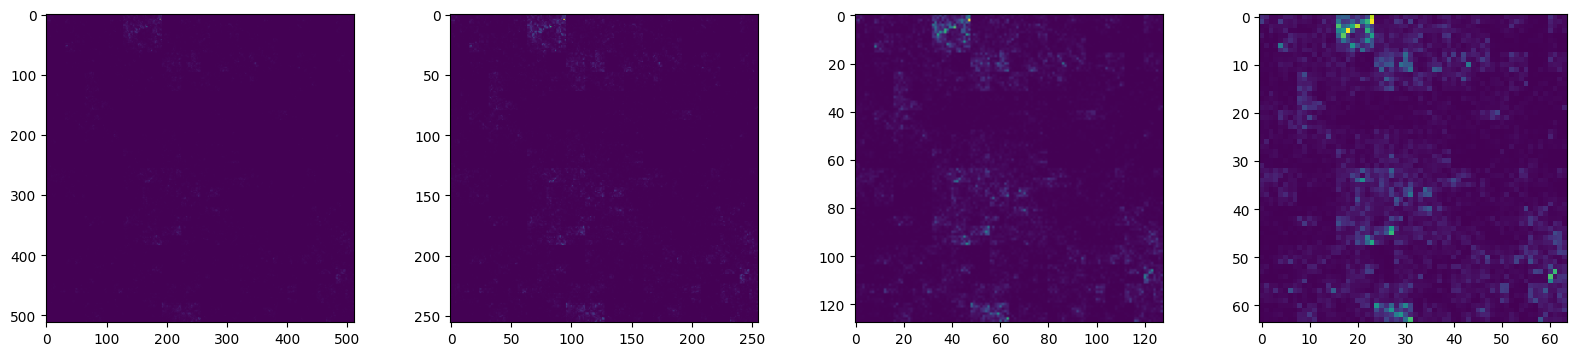

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
  small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
  axs[i].imshow(small_arr)
  print(np.var(np.log2(small_arr.flatten())))

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 6.0000e+00, 1.6000e+01,
        3.4000e+01, 6.2000e+01, 1.4200e+02, 2.4700e+02, 4.2100e+02,
        7.4800e+02, 1.1920e+03, 1.7680e+03, 2.6830e+03, 3.7470e+03,
        5.0930e+03, 6.7800e+03, 8.8420e+03, 1.0786e+04, 1.2945e+04,
        1.4528e+04, 1.6094e+04, 1.7463e+04, 1.8291e+04, 1.8548e+04,
        1.8303e+04, 1.7631e+04, 1.6390e+04, 1.4823e+04, 1.2742e+04,
        1.0715e+04, 8.5530e+03, 6.5250e+03, 4.9400e+03, 3.5250e+03,
        2.5730e+03, 1.7720e+03, 1.2430e+03, 7.8100e+02, 5.2200e+02,
        3.0000e+02, 1.7200e+02, 9.9000e+01, 5.2000e+01, 2.4000e+01,
        1.1000e+01, 5.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-29.16190272, -28.77192576, -28.38194881, -27.99197185,
        -27.60199489, -27.21201793, -26.82204098, -26.43206402,
        -26.04208706, -25.6521101 , -25.26213315, -24.87215619,
        -24.48217923, -24.09220227, -23.70222532, -23.31224836,
        -22.9222714 , -22.53229444, -22.14231749, -21.75234053

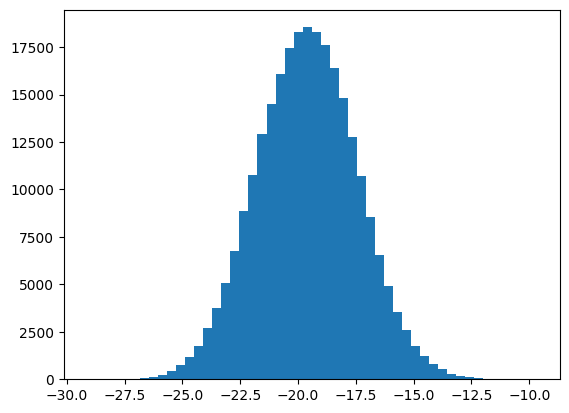

In [ ]:
plt.hist(np.log2(pop.flatten('F')), bins=50)

In [ ]:
res = []
for i in range(1000):
  lnc = multivariate_lognormal_cascade(8, sigma1=.25, sigma2=.4, corr=.0)
  pop = lnc[:,:,0]
  entropies =  []
  scales = np.array([i for i in range(3,5)])
  for i in scales:
     small_arr = block_reduce(pop, block_size=(2**i,2**i), func=np.sum)
     entropies.append(-np.sum(small_arr * np.log2(small_arr)))
  entropies = np.array(entropies)
  res.append(-np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2))
np.mean(res)

In [31]:
sigma = .25
mu = -1/2 * sigma**2 - np.log(4)

res = []
for i in range(100000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  #samples = samples / samples.sum()
  res.append(-np.sum(samples * np.log2(samples)))

print(np.mean(res))

1.954672100662974


In [25]:
res = []
for i in range(1000000):
  samples = np.exp(np.random.normal(mu, sigma, size=4))
  res.append(samples.sum())
np.mean(res)

np.float64(0.9999320967820047)

In [10]:
np.sum((entropies - entropies.mean()) * (scales - scales.mean())) / np.sum((scales - scales.mean())**2)

np.float64(-1.4638276075246432)